In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tensorflow.keras.utils import model_to_dot
import pydot

In [6]:
# Pfade für die Trainings- und Testdaten

train_dir = "./chest_xray/preprocessed_images/train"
test_dir = "./chest_xray/preprocessed_images/test"
val_dir = "./chest_xray/preprocessed_images/val"

# Hyperparameter
img_height, img_width = 224, 224
batch_size = 32
learning_rate = 0.001
num_classes = 2


In [7]:
# Bild-Generator für Trainingsdaten mit Datenaugmentation
train_datagen_1  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Bild-Generator für Testdaten ohne Datenaugmentation
test_datagen_1  = ImageDataGenerator(
    rescale=1./255 
)


# Trainingsdatengenerator
train_generator_1  = train_datagen_1.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',  # Nutze RGB für ResNet-Kompatibilität
    class_mode='binary',
    classes=["NORMAL", "PNEUMONIA"]  # Nur die beiden Ordner
)

# Testdatengenerator
test_generator_1  = test_datagen_1.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    classes=["NORMAL", "PNEUMONIA"],
    shuffle=False  # Wichtig für korrekte Evaluation
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Modell erstellen
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Vortrainierte Schichten einfrieren

model_1 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binärklassifikation
])

In [9]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping-Callback definieren
early_stopping = EarlyStopping(
    monitor='val_loss',  # Überwacht die Genauigkeit auf den Validierungsdaten
    min_delta=0.01,          # Minimale Änderung, die als Verbesserung angesehen wird
    patience=5,              # Anzahl der Epochen mit keiner Verbesserung, bevor das Training gestoppt wird
    verbose=1,               # Ausgabe von Informationen während des Trainings
    mode='min'               # Modus für die Genauigkeit (maximieren)
)

# Modell trainieren
history_1 = model_1.fit(
    train_generator_1,
    validation_data=test_generator_1,
    epochs=20,
    callbacks=[early_stopping],
)

c:\Users\dtisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7576 - loss: 2.9143 - val_accuracy: 0.7981 - val_loss: 0.5791
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8393 - loss: 0.3800 - val_accuracy: 0.8542 - val_loss: 0.3845
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8658 - loss: 0.3323 - val_accuracy: 0.8446 - val_loss: 0.4980
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8822 - loss: 0.2740 - val_accuracy: 0.8574 - val_loss: 0.4184
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8832 - loss: 0.2741 - val_accuracy: 0.8654 - val_loss: 0.4144
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8862 - loss: 0.2864 - val_accuracy: 0.8670 - val_loss: 0.4519
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8909 - loss: 0.2662 - val_accuracy: 0.8462 - val_loss: 0.4488
Epoch 7: early stopping


In [10]:
# Modell speichern
model_1.save("binary_model.keras")

In [11]:
# Konvertieren Sie das Modell in ein DOT-Format
dot = model_to_dot(model_1, show_shapes=True, show_layer_names=True)

# Erstellen Sie ein Pydot-Graph-Objekt
graph = pydot.graph_from_dot_data(dot)[0]

# Speichern Sie das Modell als PNG-Datei
output_file = 'resnet50v2_model.png'
graph.write_png(output_file)

print(f"Das Modell wurde als {output_file} gespeichert.")

TypeError: object of type 'Dot' has no len()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.62      0.75       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                    

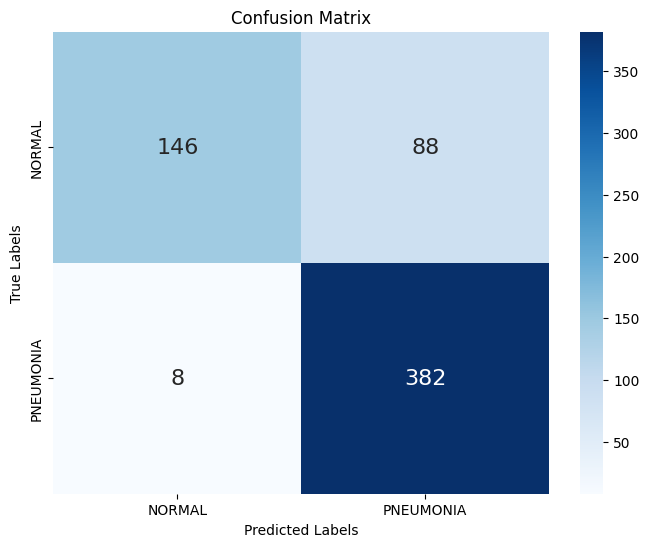

In [13]:
# Wahre Labels initialisieren
y_true = test_generator_1.classes
y_pred = []

# Anzahl der Schritte berechnen
steps = len(test_generator_1)

# Vorhersagen in Batches berechnen
for _ in range(steps):
    images, _ = next(test_generator_1)
    predictions = model_1.predict(images)
    y_pred.extend(np.round(predictions).astype(int))

# Vorhersagen in NumPy-Array umwandeln
y_pred = np.array(y_pred)

# Classification Report ausgeben
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix berechnen
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion Matrix anzeigen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"],
            annot_kws={"size": 16})  # Hier können Sie die Schriftgröße anpassen
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Grafik speichern
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()



Found 16 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


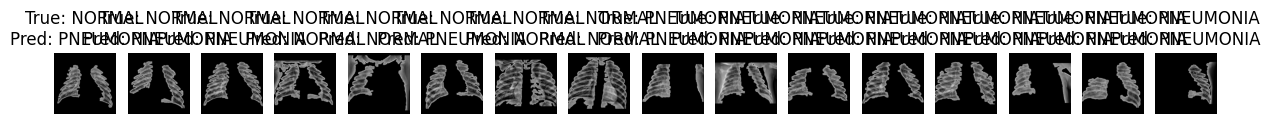

In [9]:
# Validierungsdatengenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Batch-Größe 1, um jedes Bild einzeln zu laden
    color_mode='rgb',
    class_mode='binary',
    classes=["NORMAL", "PNEUMONIA"],
    shuffle=False
)

# Vorhersagen für alle Bilder im Validierungsordner
val_steps = len(val_generator)

plt.figure(figsize=(15, 10))
for i in range(val_steps):
    image, true_label = next(val_generator)
    prediction = model_1.predict(image)
    predicted_label = np.round(prediction).astype(int)[0][0]

    # Klassennamen aus dem class_indices-Dictionary abrufen
    class_indices = val_generator.class_indices
    true_class_name = [k for k, v in class_indices.items() if v == true_label[0]][0]
    pred_class_name = [k for k, v in class_indices.items() if v == predicted_label][0]

    plt.subplot(1, val_steps, i + 1)
    plt.imshow(image[0])
    plt.title(f"True: {true_class_name}\nPred: {pred_class_name}")
    plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


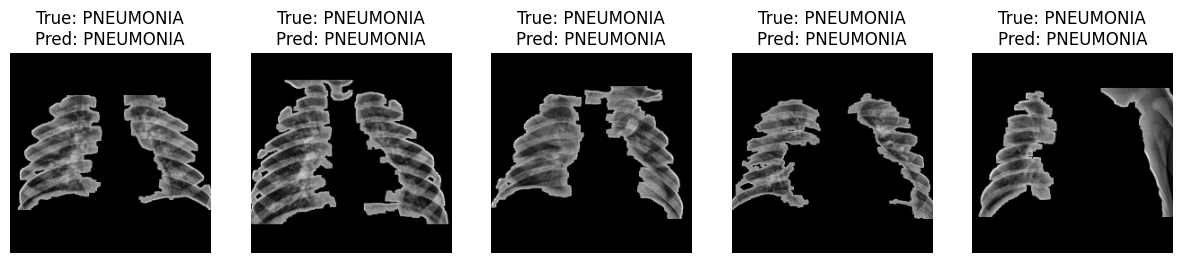

In [10]:

# Zufällige Bilder aus dem Testdatensatz auswählen und anzeigen
num_images_to_display = 5
random_indices = random.sample(range(len(test_generator_1.filenames)), num_images_to_display)

plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    image_path = test_dir + '/' + test_generator_1.filenames[index]
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    true_label = test_generator_1.classes[index]
    predicted_label = np.round(model_1.predict(image)).astype(int)[0][0]

    # Klassennamen aus dem class_indices-Dictionary abrufen
    class_indices = test_generator_1.class_indices
    true_class_name = [k for k, v in class_indices.items() if v == true_label][0]
    pred_class_name = [k for k, v in class_indices.items() if v == predicted_label][0]

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image[0])
    plt.title(f"True: {true_class_name}\nPred: {pred_class_name}")
    plt.axis('off')

plt.show()

Found 16 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


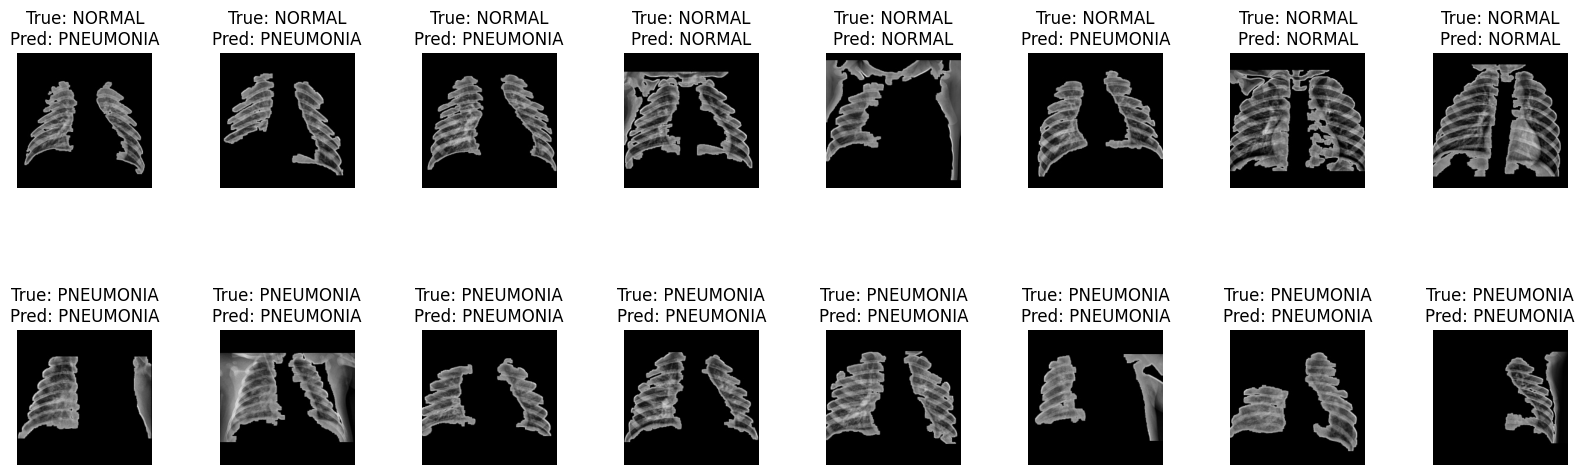

In [11]:
# Validierungsdatengenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Batch-Größe 1, um jedes Bild einzeln zu laden
    color_mode='rgb',
    class_mode='binary',
    classes=["NORMAL", "PNEUMONIA"],
    shuffle=False
)

# Vorhersagen für alle Bilder im Validierungsordner
val_steps = len(val_generator)

# Anzahl der Zeilen und Spalten berechnen
num_cols = 8
num_rows = (val_steps + num_cols - 1) // num_cols  # Aufrunden zur nächsten ganzen Zahl

plt.figure(figsize=(20, num_rows * 3))  # Größe des Plots anpassen

for i in range(val_steps):
    image, true_label = next(val_generator)
    prediction = model_1.predict(image)
    predicted_label = np.round(prediction).astype(int)[0][0]

    # Klassennamen aus dem class_indices-Dictionary abrufen
    class_indices = val_generator.class_indices
    true_class_name = [k for k, v in class_indices.items() if v == true_label[0]][0]
    pred_class_name = [k for k, v in class_indices.items() if v == predicted_label][0]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image[0])
    plt.title(f"True: {true_class_name}\nPred: {pred_class_name}")
    plt.axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Abstand zwischen den Subplots erhöhen
plt.show()